This Notebook is accompanied by the following blog-post:
http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/

In [1]:
from siml.sk_utils import *
from siml.signal_analysis_utils import *

import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict, Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 0. Loading the signals from file

In [2]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [3]:
INPUT_FOLDER_TRAIN = '../datasets/UCI_HAR/train/InertialSignals/'
INPUT_FOLDER_TEST = '../datasets/UCI_HAR/test/InertialSignals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = '../datasets/UCI_HAR/train/y_train.txt'
LABELFILE_TEST = '../datasets/UCI_HAR/test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 7352 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({6: 537, 5: 532, 1: 496, 4: 491, 2: 471, 3: 420})


# 1. Visualizations

In [4]:
N = 128
f_s = 50
t_n = 2.56
T = t_n / N
sample_rate = 1 / f_s
denominator = 10

In [5]:
signal_no = 15
signals = train_signals[signal_no, :, :]
signal = signals[:, 3]
label = train_labels[signal_no]
activity_name = activities_description[label]

## 1a. Visualization of the FFT

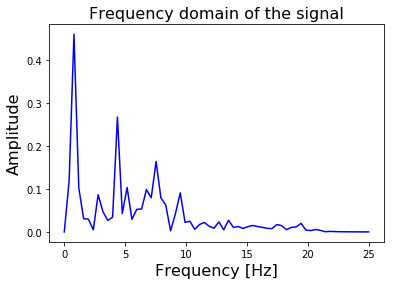

In [6]:
f_values, fft_values = get_fft_values(signal, T, N, f_s)

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

## 1b. Visualization of the PSD

/home/ataspinar/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


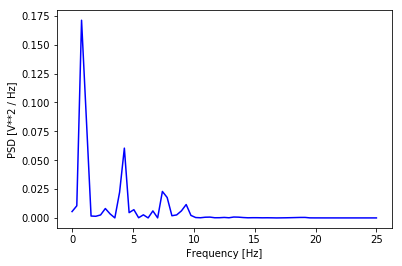

In [7]:
f_values, psd_values = get_psd_values(signal, T, N, f_s)
 
plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.show()

## 1c. Visualization of the Autocorrelation

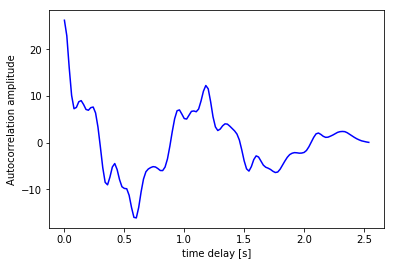

In [8]:
t_values, autocorr_values = get_autocorr_values(signal, T, N, f_s)
 
plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')
plt.show()

## 1d. Visualization of all transformations on all components

/home/ataspinar/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


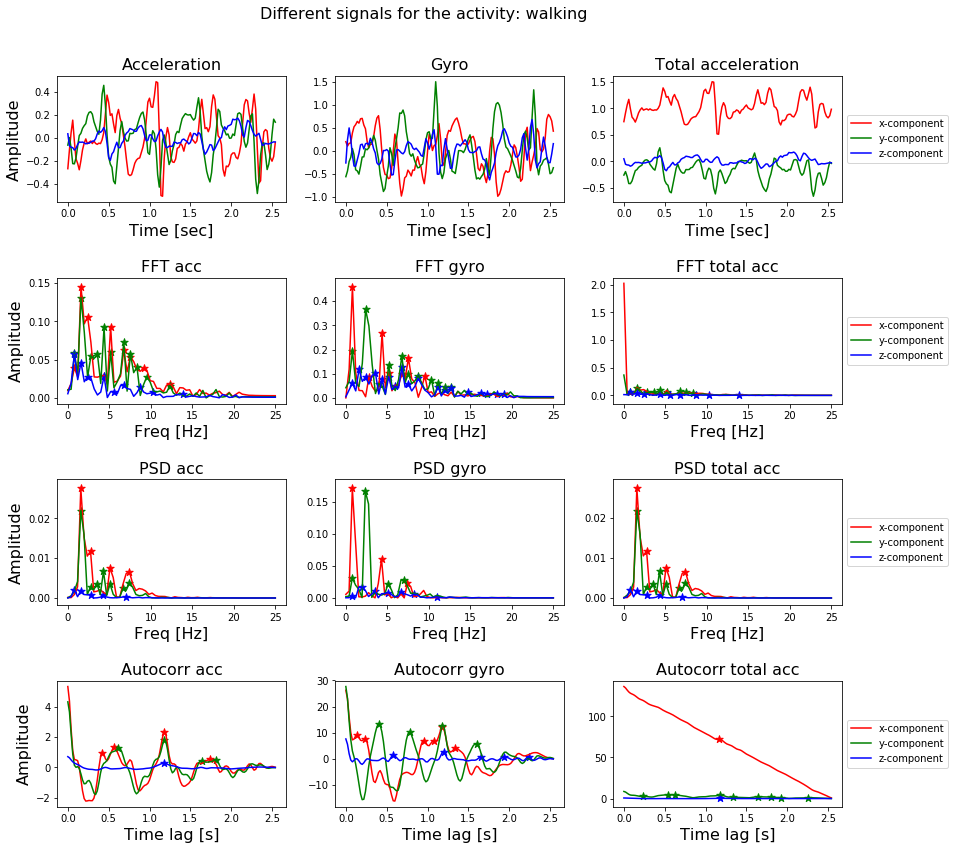

In [9]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
           ]
 
list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle.format(activity_name), fontsize=16)
 
for row_no in range(0,4):
    for comp_no in range(0,9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]
 
        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]
 
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

# 2. Extract Features from the signals

In [10]:
X_train, Y_train = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)
X_test, Y_test = extract_features_labels(test_signals, test_labels, T, N, f_s, denominator)

/home/ataspinar/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


# 3. Classification of the signals

## 3.1 Try classification with Random Forest

In [11]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.8815744825246012
             precision    recall  f1-score   support

          1       0.93      0.98      0.96       496
          2       0.93      0.96      0.94       471
          3       0.96      0.88      0.92       420
          4       0.80      0.73      0.76       491
          5       0.78      0.93      0.85       532
          6       0.91      0.82      0.86       537

avg / total       0.88      0.88      0.88      2947



## 3.2 Try out several classifiers (to see which one initially scores best)

In [12]:
#See https://github.com/taspinar/siml
dict_results = batch_classify(X_train, Y_train, X_test, Y_test)
display_dict_models(dict_results)

trained Gradient Boosting Classifier in 87.67 s
trained Random Forest in 0.52 s
trained Logistic Regression in 17.53 s
trained Nearest Neighbors in 0.62 s
trained Decision Tree in 1.45 s


,classifier,train_score,test_score,train_time
0,Gradient Boosting Classifier,0.990751,0.899559,87.668457
1,Random Forest,0.998096,0.857482,0.524725
2,Logistic Regression,0.882617,0.811673,17.526514
4,Decision Tree,1.000000,0.787920,1.448587
3,Nearest Neighbors,0.854461,0.688497,0.622217


## 3.3 Hyperparameter optimization of best classifier

In [ ]:
GDB_params = {
    'n_estimators': [100, 200, 5000],
    'learning_rate': [0.5, 0.1, 0.01, 0.001],
    'criterion': ['friedman_mse', 'mse']
}

for n_est in GDB_params['n_estimators']:
    for lr in GDB_params['learning_rate']:
        for crit in GDB_params['criterion']:
            clf = GradientBoostingClassifier(n_estimators=n_est, 
                                             learning_rate = lr,
                                             criterion = crit)
            clf.fit(X_train, Y_train)
            train_score = clf.score(X_train, Y_train)
            test_score = clf.score(X_test, Y_test)
            print("For ({}, {}, {}) - train, test score: \t {:.5f} \t-\t {:.5f}".format(
                n_est, lr, crit[:4], train_score, test_score)
                 )